In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [2]:
BATCH_SIZE = 128
Z_DIM = 100
LR = 2e-4
BETAS = (0.5, 0.999)
N_EPOCHS = 5

os.makedirs("/content/data", exist_ok=True)

# FashionMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [0,1] -> [-1,1]
])

train_dataset = datasets.FashionMNIST(
    root="/content/data", train=True, download=True, transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

In [3]:
class DCGAN_Generator(nn.Module):
    """
    z: [B, Z_DIM, 1, 1] -> img: [B, 1, 28, 28] in [-1,1]
    """
    def __init__(self, z_dim=100, ngf=64):
        super().__init__()
        self.net = nn.Sequential(
            # (B, z_dim, 1, 1) -> (B, ngf*4, 7, 7)
            nn.ConvTranspose2d(z_dim, ngf*4, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            # (B, ngf*4, 7, 7) -> (B, ngf*2, 14, 14)
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            # (B, ngf*2, 14, 14) -> (B, 1, 28, 28)
            nn.ConvTranspose2d(ngf*2, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


class DCGAN_Discriminator(nn.Module):
    """
    img: [B,1,28,28] -> logit: [B,1]
    """
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            # (B,1,28,28) -> (B, ndf, 14, 14)
            nn.Conv2d(1, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (B,ndf,14,14) -> (B, ndf*2, 7, 7)
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (B,ndf*2,7,7) -> (B,1,1,1)
            nn.Conv2d(ndf*2, 1, kernel_size=7, stride=1, padding=0, bias=False)
        )

    def forward(self, x):
        out = self.net(x)       # (B,1,1,1)
        return out.view(-1, 1)  # (B,1)

def dcgan_weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = DCGAN_Generator(z_dim=Z_DIM).to(device)
D = DCGAN_Discriminator().to(device)

G.apply(dcgan_weights_init)
D.apply(dcgan_weights_init)

DCGAN_Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
  )
)

In [4]:
criterion = nn.BCEWithLogitsLoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)

# Fixed noise for consistent visualization
fixed_z = torch.randn(64, Z_DIM, 1, 1, device=device)

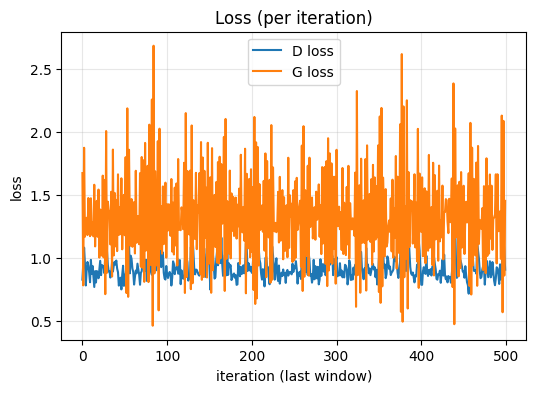

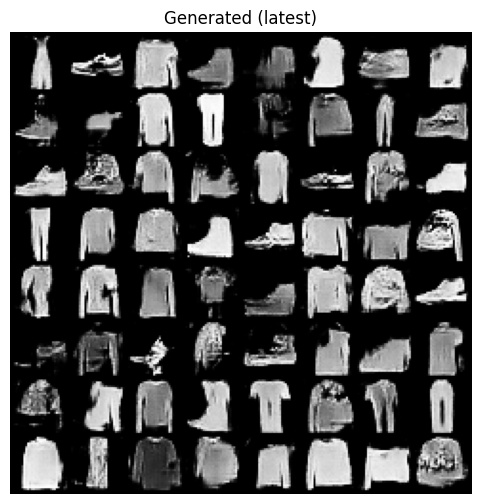

In [6]:
D_hist, G_hist = [], []

def show_live(D_hist, G_hist, fake_imgs, max_points=500):
    """
    fake_imgs: [64,1,28,28] in [-1,1]
    """
    clear_output(wait=True)

    d_plot = D_hist[-max_points:]
    g_plot = G_hist[-max_points:]

    plt.figure(figsize=(6,4))
    plt.plot(d_plot, label="D loss")
    plt.plot(g_plot, label="G loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title("Loss (per iteration)")
    plt.xlabel("iteration (last window)")
    plt.ylabel("loss")
    plt.show()

    imgs = (fake_imgs + 1) / 2  # [-1,1] -> [0,1]
    grid = make_grid(imgs, nrow=8, padding=2)
    grid_np = grid.detach().cpu().permute(1,2,0).numpy()

    plt.figure(figsize=(6,6))
    plt.imshow(grid_np, cmap="gray")
    plt.axis("off")
    plt.title("Generated (latest)")
    plt.show()

global_iter = 0

for epoch in range(1, N_EPOCHS + 1):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{N_EPOCHS}")

    for real_imgs, _ in pbar:
        real_imgs = real_imgs.to(device, non_blocking=True)  # [B,1,28,28]
        B = real_imgs.size(0)

        y_real = torch.ones(B, 1, device=device)
        y_fake = torch.zeros(B, 1, device=device)

        # ---- Train Discriminator ----
        d_optimizer.zero_grad()

        real_logits = D(real_imgs)
        d_real_loss = criterion(real_logits, y_real)

        z = torch.randn(B, Z_DIM, 1, 1, device=device)
        fake_imgs = G(z)
        fake_logits = D(fake_imgs.detach())
        d_fake_loss = criterion(fake_logits, y_fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # ---- Train Generator ----
        g_optimizer.zero_grad(set_to_none=True)

        fake_logits_for_g = D(fake_imgs)
        g_loss = criterion(fake_logits_for_g, y_real)
        g_loss.backward()
        g_optimizer.step()

        D_hist.append(d_loss.item())
        G_hist.append(g_loss.item())
        global_iter += 1

        with torch.no_grad():
            sample = G(fixed_z)
        show_live(D_hist, G_hist, sample)

        pbar.set_postfix(d_loss=float(d_loss.item()), g_loss=float(g_loss.item()))